# Generative Adversarial Networks

## Common Functions

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")

device is cuda


In [3]:
# Show sample some images of a batch
def show_images(batch, num_images=8, num_rows=2, num_cols=4):
    batch = batch.squeeze()
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(batch[i], cmap="gray")
        plt.axis(False)
    plt.show()

In [4]:
# Create a noise vector
def create_noise(batch_size, noise_size, mode_noise, device):
    if mode_noise == 'uniform':
        input_z = torch.rand(size=(batch_size, noise_size), device=device) * 2 - 1
    elif mode_noise == 'normal':
        input_z = torch.randn(size=(batch_size, noise_size), device=device)
    return input_z

In [5]:
# Save the model
from pathlib import Path

def save_generative_adversarial_model(generator:nn.Module,
                                      discriminator:nn.Module,
                                      methodology:str):
    # 1. Create models directory
    MODEL_PATH = Path("models/"+methodology)
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    # 2. Create a model save path for generator and discriminator models
    MODEL_NAME_G = "generator.pth" #files most be saved with the extension of either .pth or .pt
    MODEL_NAME_D = "discriminator.pth"

    MODEL_SAVE_PATH_G = MODEL_PATH / MODEL_NAME_G
    MODEL_SAVE_PATH_D = MODEL_PATH / MODEL_NAME_D

    # Save models state_dict()
    print(f"Saving model to: {MODEL_SAVE_PATH_G}")
    torch.save(obj=generator.state_dict(), f=MODEL_SAVE_PATH_G)

    print(f"Saving model to: {MODEL_SAVE_PATH_D}")
    torch.save(obj=discriminator.state_dict(), f=MODEL_SAVE_PATH_D)

## 1. Vanilla GAN

### 1.1 Generator Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_units, output_shape):
        super().__init__()

        self.model = nn.Sequential(nn.Linear(input_size, hidden_units),
                                   nn.LeakyReLU(0.01),
                                   nn.Linear(hidden_units, np.prod(output_shape)),
                                   nn.Tanh(),
                                   nn.Unflatten(1, output_shape))
        
    def forward(self, z):
        return self.model(z)

In [ ]:
z = torch.randn(size=(32, 20), device=device)

output_shape = (1, 28, 28)

generator_test = Generator(input_size=20, hidden_units=100, output_shape=output_shape).to(device)

print(generator_test)

generator_test.eval()
with torch.inference_mode():
    generated_images = generator_test(z)
    print(generated_images.shape)
    plt.imshow(generated_images[0][0].cpu(),  cmap="gray")


### 1.2 Discriminator Network

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, hidden_units):
        super().__init__()
        
        self.model = nn.Sequential(nn.Flatten(),
                                   nn.Linear(np.prod(input_shape), hidden_units),
                                   nn.LeakyReLU(0.01),
                                   nn.Dropout(0.5),
                                   nn.Linear(hidden_units, 1),
                                   nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

In [ ]:
input_shape = generated_images[0].shape
discriminator_test = Discriminator(input_shape=input_shape, hidden_units=100).to(device)

print(discriminator_test)

discriminator_test.eval()
with torch.inference_mode():
    prob = discriminator_test(generated_images[0])
    print(prob)

### 1.3 Loading MNIST Dataset

In [ ]:
image_path = "./"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)) # Normalize images pixels values to be rescaled in the range [-1, 1]
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform=transform, download=True
)

image, label = next(iter(mnist_dataset))
print(f"image shape: {image.shape} | image min value: {image.min()} | image max value: {image.max()}")

### 1.4 Creating Data Loader

In [ ]:
batch_size = 32
mode_noise = 'uniform'
noise_size = 20

data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

input_real, label = next(iter(data_loader))
# input_real = input_real.view(batch_size, -1)

input_z = create_noise(batch_size, noise_size, mode_noise, device=device)
print(f"noise vector shape: {input_z.shape} | real image shape: {input_real.shape}")
show_images(input_real)

### 1.5 Defining hyperparameters, generator, discriminator, loss function and optimizers 

In [ ]:
batch_size = 32
noise_size = 20
hidden_units = 100

torch.manual_seed(42)
np.random.seed(42)

mnist_dataloader = DataLoader(mnist_dataset, batch_size=batch_size,
                              shuffle=True, drop_last=True) # Drop Last parameter ignores the last batch

image_shape = next(iter(mnist_dataloader))[0][0].shape

generator = Generator(noise_size, hidden_units, image_shape).to(device)
discriminator = Discriminator(image_shape, hidden_units).to(device)

loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(params=generator.parameters())
d_optimizer = torch.optim.Adam(params=discriminator.parameters())

### 1.6 Training Loop

In [ ]:
### Training the generative adversarial network
def train(dataloader:DataLoader, batch_size:int, discriminator:nn, genereator:nn, loss_fn:nn,
           g_optimizer:torch.optim.Optimizer, d_optimizer:torch.optim.Optimizer, device):
    
    valid_labels = torch.ones(size=(batch_size,1), device=device)
    fake_labels = torch.zeros(size=(batch_size,1), device=device)

    for i, batch in enumerate(dataloader):
        real_image, label = batch
        real_image = real_image.to(device)
        # print(real_image.shape)

        ## Training Discriminator
        discriminator.train()
        noise_vec = create_noise(batch_size, noise_size, mode_noise, device)
        fake_image = generator(noise_vec)

        # Forward pass
        d_prob_real = discriminator(real_image)
        d_prob_fake = discriminator(fake_image)

        # Calculate the loss
        d_loss_real = loss_fn(d_prob_real, valid_labels)
        d_loss_fake = loss_fn(d_prob_fake, fake_labels)
        d_loss = d_loss_fake + d_loss_real

        # Optimizer zero grad
        d_optimizer.zero_grad()

        # Loss backward
        d_loss.backward()

        # Optimizer step
        d_optimizer.step()

        ## Triaining Generator
        generator.train()

        # Forward pass
        noise_vec = create_noise(batch_size, noise_size, mode_noise, device)
        fake_image = generator(noise_vec)

        # Calculate the loss
        g_prob_fake = discriminator(fake_image)
        g_loss = loss_fn(g_prob_fake, valid_labels)

        # Optimizer zero grad
        g_optimizer.zero_grad()

        # Loss backward
        g_loss.backward()

        # Optimizer step
        g_optimizer.step()
        
        if (i+1)%500 == 0: 
            print(f"Batch: {i+1}/{len(dataloader)} | Discriminator Loss: {d_loss} | Generator Loss: {g_loss}")
    return (d_loss_real, d_loss_fake, d_loss, g_loss)

In [ ]:
# Training for number of epochs
num_epochs = 100

all_d_fake_losses = []
all_d_real_losses = []
all_d_losses = []
all_g_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")
    d_loss_real, d_loss_fake, d_loss, g_loss = train(dataloader=data_loader, batch_size=32,
          discriminator=discriminator, genereator=generator,
          loss_fn=loss_fn, g_optimizer=g_optimizer, d_optimizer=d_optimizer,
          device=device)
    
    all_d_real_losses.append(d_loss_real.cpu().detach().numpy())
    all_d_fake_losses.append(d_loss_fake.cpu().detach().numpy())
    all_d_losses.append(d_loss.cpu().detach().numpy())
    all_g_losses.append(g_loss.cpu().detach().numpy())

    ## Evaluation
    if (epoch+1) % 10 == 0:
        generator.eval()
        with torch.inference_mode():
            noise_vec = create_noise(batch_size, noise_size, mode_noise, device)
            fake_images = generator(noise_vec)
            show_images(fake_images.cpu(), num_images=8, num_cols=4, num_rows=2)
          

### 1.7 Plotting losses for generator and discriminator

In [ ]:
# Ploting losses
all_g_losses = [all_g_loss for all_g_loss in all_g_losses]
print(all_g_losses)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(all_g_losses, label='Generator Loss')

half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator Loss')

plt.legend(fontsize=20)
ax.set_xlabel('iteration', size=15)
ax.set_ylabel('Loss', size=15)

## 2. Deep Convolutional Generative Adversarial Network

### 2.1 Generator Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, n_filters):
        super().__init__()
        self.model = nn.Sequential(nn.ConvTranspose2d(input_size, n_filters*4,
                                                       kernel_size=4, stride=1,
                                                       padding=0, bias=False),
                                    nn.BatchNorm2d(n_filters*4),
                                    nn.LeakyReLU(0.2),
                                    nn.ConvTranspose2d(n_filters*4, n_filters*2,
                                                       kernel_size=3, stride=2,
                                                       padding=1, bias=False),
                                    nn.BatchNorm2d(n_filters*2),
                                    nn.LeakyReLU(0.2),
                                    nn.ConvTranspose2d(n_filters*2, n_filters,
                                                       kernel_size=4, stride=2,
                                                       padding=1, bias=False),
                                    nn.BatchNorm2d(n_filters),
                                    nn.LeakyReLU(0.2),
                                    nn.ConvTranspose2d(n_filters, 1,
                                                       kernel_size=4, stride=2,
                                                       padding=1, bias=False),
                                    nn.Tanh())
    
    def forward(self, z):
        return self.model(z)

In [ ]:
z_size = 100
n_filters = 32

generator_test  = Generator(input_size=z_size, n_filters=n_filters).to(device)

print(generator_test)

z = torch.randn(size=(32,100,1,1), device=device)
generator_test.eval()
with torch.inference_mode():
    generated_image = generator_test(z)
    print(generated_image.shape)

### 2.2 Discriminator Network

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(1, n_filters,
                                              kernel_size=4, stride=2,
                                              padding=1, bias=False),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv2d(n_filters, n_filters*2,
                                             kernel_size=4, stride=2,
                                             padding=1, bias=False),
                                   nn.BatchNorm2d(n_filters*2),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv2d(n_filters*2, n_filters*4,
                                             kernel_size=3, stride=2,
                                             padding=1, bias=False),
                                   nn.BatchNorm2d(n_filters*4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv2d(n_filters*4, 1,
                                             kernel_size=4,stride=1,
                                             padding=0, bias=False),
                                   nn.Sigmoid())
    def forward(self, x):
        output = self.model(x)
        return output.view(-1, 1).squeeze(0)

In [ ]:
n_filters=32
discriminator_test = Discriminator(n_filters=n_filters).to(device)
print(discriminator_test)

sample_batch = torch.randn(size=(32,1, 28, 28), device=device)

discriminator_test.eval()
with torch.inference_mode():
    prob = discriminator_test(sample_batch)
    print(prob.shape)

### 2.3 Loading MNIST Dataset

In [ ]:
image_path = "./"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)) # Normalize images pixels values to be rescaled in the range [-1, 1]
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform=transform, download=True
)

image, label = next(iter(mnist_dataset))
print(f"image shape: {image.shape} | image min value: {image.min()} | image max value: {image.max()}")

### 2.4 Creating Data Loader

In [ ]:
batch_size = 32
mode_noise = 'uniform'
noise_size = 100

data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

input_real, label = next(iter(data_loader))
# input_real = input_real.view(batch_size, -1)

input_z = create_noise(batch_size, noise_size, mode_noise, device=device)
print(f"noise vector shape: {input_z.shape} | real image shape: {input_real.shape}")
show_images(input_real)

### 2.5 Defining hyperparameters, generator, discriminator, loss function and optimizers

In [42]:
batch_size = 32
mode_noise = 'uniform'
noise_size = 100
n_filters = 32

generator = Generator(noise_size, n_filters).to(device)
discriminator = Discriminator(n_filters).to(device)

loss_fn = nn.BCELoss()
optimizer_g = torch.optim.Adam(params=generator.parameters(), lr=0.0003)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=0.0002)

### 2.6 Training Loop

In [43]:
def train(dataloader:DataLoader,
          generator:nn.Module,
          discriminator:nn.Module,
          loss_fn:nn.Module,
          optimizer_d:torch.optim.Optimizer,
          optimizer_g:torch.optim.Optimizer,
          batch_size:int,
          noise_size:int,
          mode_noise:str,
          device:str):
    
    valid_labels = torch.ones(size=(batch_size, 1), device=device)
    fake_labels = torch.zeros(size=(batch_size, 1), device=device)

    for i, batch in enumerate(dataloader):
        image_real, label_real = batch
        image_real = image_real.to(device)
      #   print(type(image_real))
        ## Training Discriminator
        discriminator.train()
        ### Forward pass
        z_vector = create_noise(batch_size, noise_size, mode_noise, device).unsqueeze(dim=2).unsqueeze(dim=3)
        image_fake = generator(z_vector)
        prob_real = discriminator(image_real)
        prob_fake = discriminator(image_fake)
        ### Calculate loss
        loss_d_real = loss_fn(prob_real, valid_labels)
        loss_d_fake = loss_fn(prob_fake, fake_labels)
        loss_d = loss_d_real + loss_d_fake
        ###  Optimizer zero grad
        optimizer_d.zero_grad()
        ### Loss backward
        loss_d.backward()
        ### Optimizer step
        optimizer_d.step()
        
        ## Training Generator
        generator.train()
        ### Forward pass
        z_vector = create_noise(batch_size, noise_size, mode_noise, device).unsqueeze(dim=2).unsqueeze(dim=3)
        image_fake = generator(z_vector)
        prob_fake = discriminator(image_fake)
        ### Calculate the loss
        loss_g = loss_fn(prob_fake, valid_labels)
        ### Optimzer zero grad
        optimizer_g.zero_grad()
        ### Loss backward
        loss_g.backward()
        ### Optimizer step
        optimizer_g.step()
        if (i+1) % 500 == 0:
              print(f"Batch {i+1}/{len(dataloader)} | Discriminator Loss: {loss_d} | Generator Loss: {loss_g}")
    return (loss_d, loss_g)


Epoch: 1
Batch 500/1875 | Discriminator Loss: 0.20200228691101074 | Generator Loss: 5.583239555358887
Batch 1000/1875 | Discriminator Loss: 0.12081443518400192 | Generator Loss: 4.879373550415039
Batch 1500/1875 | Discriminator Loss: 0.18039637804031372 | Generator Loss: 4.593994140625

Epoch: 2
Batch 500/1875 | Discriminator Loss: 0.5184522867202759 | Generator Loss: 2.2701194286346436
Batch 1000/1875 | Discriminator Loss: 0.3564128875732422 | Generator Loss: 3.556835174560547
Batch 1500/1875 | Discriminator Loss: 0.723896861076355 | Generator Loss: 2.843599796295166

Epoch: 3
Batch 500/1875 | Discriminator Loss: 0.18396669626235962 | Generator Loss: 2.178955078125
Batch 1000/1875 | Discriminator Loss: 0.26871776580810547 | Generator Loss: 1.4650429487228394
Batch 1500/1875 | Discriminator Loss: 0.8353833556175232 | Generator Loss: 2.5823283195495605

Epoch: 4
Batch 500/1875 | Discriminator Loss: 0.42531275749206543 | Generator Loss: 3.8726794719696045
Batch 1000/1875 | Discriminator

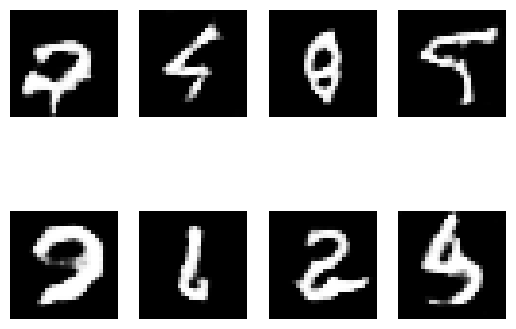


Epoch: 6
Batch 500/1875 | Discriminator Loss: 0.2586435377597809 | Generator Loss: 2.27500581741333
Batch 1000/1875 | Discriminator Loss: 0.300256609916687 | Generator Loss: 3.2662620544433594
Batch 1500/1875 | Discriminator Loss: 0.21457554399967194 | Generator Loss: 1.8577653169631958

Epoch: 7
Batch 500/1875 | Discriminator Loss: 0.04618197679519653 | Generator Loss: 2.5550644397735596
Batch 1000/1875 | Discriminator Loss: 0.01767527125775814 | Generator Loss: 4.265211582183838
Batch 1500/1875 | Discriminator Loss: 0.31832224130630493 | Generator Loss: 4.04647970199585

Epoch: 8
Batch 500/1875 | Discriminator Loss: 0.2423257827758789 | Generator Loss: 4.656842231750488
Batch 1000/1875 | Discriminator Loss: 0.0858248919248581 | Generator Loss: 2.3503687381744385
Batch 1500/1875 | Discriminator Loss: 0.12338688224554062 | Generator Loss: 3.8730826377868652

Epoch: 9
Batch 500/1875 | Discriminator Loss: 0.5098925232887268 | Generator Loss: 4.927457332611084
Batch 1000/1875 | Discrimin

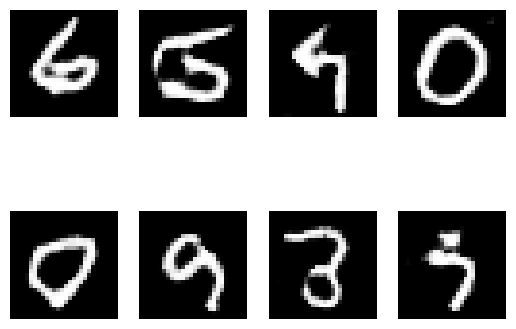


Epoch: 11
Batch 500/1875 | Discriminator Loss: 0.2514239251613617 | Generator Loss: 4.821900367736816
Batch 1000/1875 | Discriminator Loss: 0.15719518065452576 | Generator Loss: 4.1135406494140625
Batch 1500/1875 | Discriminator Loss: 0.14416436851024628 | Generator Loss: 4.349469184875488

Epoch: 12
Batch 500/1875 | Discriminator Loss: 0.18079151213169098 | Generator Loss: 4.251817226409912
Batch 1000/1875 | Discriminator Loss: 0.2710319459438324 | Generator Loss: 2.606354236602783
Batch 1500/1875 | Discriminator Loss: 0.09060734510421753 | Generator Loss: 3.639263868331909

Epoch: 13
Batch 500/1875 | Discriminator Loss: 0.08945488929748535 | Generator Loss: 6.607913970947266
Batch 1000/1875 | Discriminator Loss: 0.02772563509643078 | Generator Loss: 4.263968467712402
Batch 1500/1875 | Discriminator Loss: 0.09625743329524994 | Generator Loss: 3.946671962738037

Epoch: 14
Batch 500/1875 | Discriminator Loss: 0.1999586671590805 | Generator Loss: 5.5326762199401855
Batch 1000/1875 | Dis

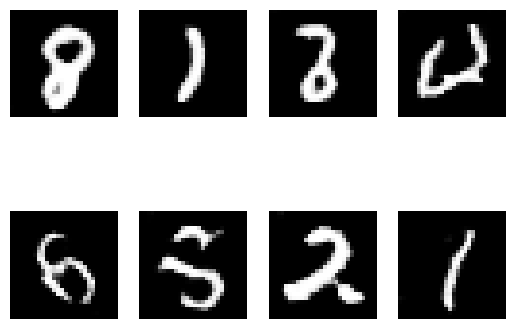


Epoch: 16
Batch 500/1875 | Discriminator Loss: 0.06745448708534241 | Generator Loss: 3.9433937072753906
Batch 1000/1875 | Discriminator Loss: 0.13501574099063873 | Generator Loss: 4.729203224182129
Batch 1500/1875 | Discriminator Loss: 0.09913815557956696 | Generator Loss: 6.603196144104004

Epoch: 17
Batch 500/1875 | Discriminator Loss: 0.08018813282251358 | Generator Loss: 4.842060565948486
Batch 1000/1875 | Discriminator Loss: 0.034487783908843994 | Generator Loss: 3.0234570503234863
Batch 1500/1875 | Discriminator Loss: 0.08425292372703552 | Generator Loss: 2.8505711555480957

Epoch: 18
Batch 500/1875 | Discriminator Loss: 0.17679843306541443 | Generator Loss: 2.2103841304779053
Batch 1000/1875 | Discriminator Loss: 0.1356271654367447 | Generator Loss: 4.798044204711914
Batch 1500/1875 | Discriminator Loss: 0.07872051000595093 | Generator Loss: 4.405983924865723

Epoch: 19
Batch 500/1875 | Discriminator Loss: 0.146473228931427 | Generator Loss: 3.9678168296813965
Batch 1000/1875 |

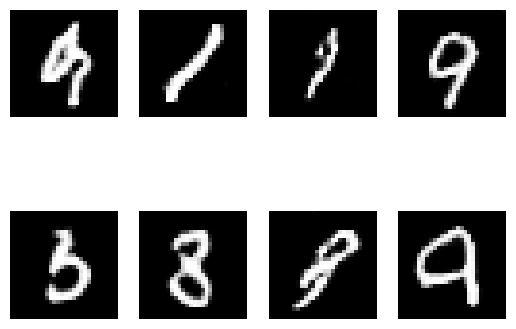

In [44]:
epochs = 20
batch_size = 32
mode_noise = 'uniform'
noise_size = 100

loss_d_all = []
loss_g_all = []

for epoch in range(epochs):
    print(f"\nEpoch: {epoch+1}")
    loss_d, loss_g = train(data_loader,
                           generator,
                           discriminator,
                           loss_fn,
                           optimizer_d,
                           optimizer_g,
                           batch_size,
                           noise_size,
                           mode_noise,
                           device)
    loss_d_all.append(loss_d)
    loss_g_all.append(loss_g)

    if (epoch+1) % 5 == 0:
        generator.eval()
        with torch.inference_mode():
            z = create_noise(batch_size,
                             noise_size,
                             mode_noise,
                             device).unsqueeze(dim=2).unsqueeze(dim=3)
            image_generated = generator(z)
            show_images(image_generated.cpu())

## 3. Conditional Generative Adversarial Networks

### 3.1 Generator Network

In [314]:
class Generator(nn.Module):
    def __init__(self, z_size, label_size, n_filters):
        super().__init__()

        self.model = nn.Sequential( nn.Flatten(),
                                    nn.Linear(z_size+label_size, 7*7*128),
                                    nn.Unflatten(1, (128, 7, 7)),
                                    nn.BatchNorm2d(n_filters*4),
                                    nn.ConvTranspose2d(n_filters*4, n_filters*4,
                                                       kernel_size=4, stride=2,
                                                       padding=1, bias=False),
                                    nn.BatchNorm2d(n_filters*4),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(n_filters*4, n_filters*2,
                                                       kernel_size=4, stride=2,
                                                       padding=1, bias=False),
                                    nn.BatchNorm2d(n_filters*2),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(n_filters*2, n_filters,
                                                       kernel_size=3, stride=1,
                                                       padding=1, bias=False),
                                    nn.BatchNorm2d(n_filters),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(n_filters, 1,
                                                       kernel_size=3, stride=1,
                                                       padding=1, bias=False),
                                    nn.Tanh())
    def forward(self, z, y):
        concated_inputs = torch.cat((z, y), dim=1)
        return self.model(concated_inputs)        

In [315]:
z = torch.randn((32, 100, 1, 1))
y = torch.zeros((32, 10, 1, 1))
y[:,torch.randint(0, 10, size=(1,))] = 1
generator_test = Generator(z_size=100, label_size=10, n_filters=32)

generator_test.eval()
with torch.inference_mode():
    generated_image = generator_test(z, y)
    # print(f"Label:{y[:1]}\n")
    print(f"Genrated image:{generated_image[:1].shape}")

Genrated image:torch.Size([1, 1, 28, 28])


### 3.2 Discriminator Network

In [316]:
class Discriminator(nn.Module):
    def __init__(self, label_size, n_filters):
        super().__init__()
        
        self.label = nn.Sequential(nn.Flatten(),
                                   nn.Linear(label_size, 7*7*16),
                                   nn.Unflatten(1, (1, 28, 28)))
        
        self.model = nn.Sequential(nn.LeakyReLU(0.2),
                                    nn.Conv2d(2, n_filters,
                                              kernel_size=4, stride=2,
                                              padding=1, bias=False),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv2d(n_filters, n_filters*2,
                                             kernel_size=4, stride=2,
                                             padding=1, bias=False),
                                #    nn.BatchNorm2d(n_filters*2),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv2d(n_filters*2, n_filters*4,
                                             kernel_size=3, stride=2,
                                             padding=1, bias=False),
                                #    nn.BatchNorm2d(n_filters*4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv2d(n_filters*4, 1,
                                             kernel_size=4,stride=1,
                                             padding=0, bias=False),
                                   nn.Sigmoid())
    def forward(self, x, y):
        label_features = self.label(y)
        # print(label_features.shape)
        concated_inputs = torch.cat((x, label_features), dim=1)
        return self.model(concated_inputs).view(-1, 1).squeeze(0)

In [317]:
discriminator_test = Discriminator(label_size=10, n_filters=32)

sample_batch = torch.randn((32, 1, 28, 28))
sample_labels = torch.zeros((32, 10, 1, 1))
sample_labels[:,torch.randint(0, 10, size=(1,))] = 1

discriminator_test.eval()
with torch.inference_mode():
    probs = discriminator_test(sample_batch, sample_labels)
    print(probs.shape)

torch.Size([32, 1])


### 3.3 Loading MNIST Dataset

In [318]:
image_path = "./"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)) # Normalize images pixels values to be rescaled in the range [-1, 1]
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform=transform, download=True
)

image, label = next(iter(mnist_dataset))
print(f"image shape: {image.shape} | image min value: {image.min()} | image max value: {image.max()}")

image shape: torch.Size([1, 28, 28]) | image min value: -1.0 | image max value: 1.0


### 3.4 Creating Data Loader

noise vector shape: torch.Size([32, 100]) | real image shape: torch.Size([32, 1, 28, 28])


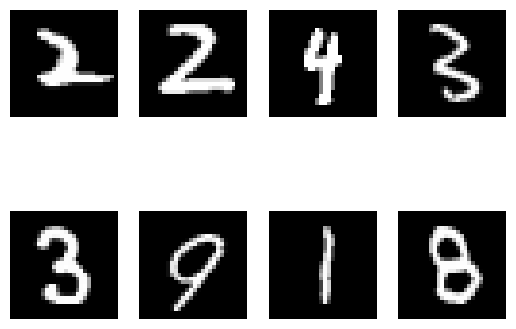

In [319]:
batch_size = 32
mode_noise = 'uniform'
noise_size = 100
label_size = 10
n_filters = 32

data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

input_real, label = next(iter(data_loader))
# input_real = input_real.view(batch_size, -1)

input_z = create_noise(batch_size, noise_size, mode_noise, device=device)
print(f"noise vector shape: {input_z.shape} | real image shape: {input_real.shape}")
show_images(input_real)

### 3.5 Defining hyperparameters, generators, discriminators, loss function and optimizers

In [320]:
generator = Generator(z_size=noise_size,
                       label_size=label_size,
                         n_filters=n_filters).to(device)
discriminator = Discriminator(label_size, n_filters).to(device)

loss_fn = nn.BCELoss()

optimizer_g = torch.optim.Adam(params=generator.parameters(), lr=0.0003)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=0.0002)

In [321]:
def one_hot_encoder(data, data_size, batch_size, device):
    encoded_data = torch.zeros(size=(batch_size, data_size, 1, 1), device=device)
    ones_idxs = [data[i] for i in range(batch_size)]
    for i in range(batch_size):
        encoded_data[i,ones_idxs[i]] = 1
    return encoded_data

In [322]:
def random_labels(data_size, batch_size, device):
    sample_labels = torch.zeros((batch_size, data_size, 1, 1), device=device)
    for i in range(batch_size):
        sample_labels[i,torch.randint(0, 10, size=(1,))] = 1
    return sample_labels

In [323]:
encoded_data = random_labels(data_size=10, batch_size=32, device=device)
# print(encoded_data[0:3])

### 3.6 Training Loop

In [324]:
def train(dataloader:DataLoader,
          generator:nn.Module,
          discriminator:nn.Module,
          loss_fn:nn.Module,
          optimizer_d:torch.optim.Optimizer,
          optimizer_g:torch.optim.Optimizer,
          batch_size:int,
          noise_size:int,
          mode_noise:str,
          device:str):
    
    valid = torch.ones(size=(batch_size, 1), device=device)
    fake  = torch.zeros(size=(batch_size, 1), device=device)

    for i, batch in enumerate(dataloader):
        images_real, labels_real = batch
        images_real, labels_real = images_real.to(device), labels_real.to(device)

        ## Training Discriminator
        discriminator.train()

        ### Forward pass
        z = create_noise(batch_size, noise_size, mode_noise, device).unsqueeze(dim=2).unsqueeze(dim=3)
        labels_fake = random_labels(data_size=10, batch_size=batch_size, device=device)
        labels_real = one_hot_encoder(labels_real, data_size=10, batch_size=batch_size, device=device)

        images_fake = generator(z, labels_fake)
      #   print(images_fake.shape)

        prob_fake = discriminator(images_fake, labels_fake)
        prob_real = discriminator(images_real, labels_real)

        ### Calculate the loss
        loss_d_fake = loss_fn(prob_fake, fake)
        loss_d_real = loss_fn(prob_real, valid)
        loss_d = loss_d_fake + loss_d_real

        ### Optimizer zero grad
        optimizer_d.zero_grad()

        ### Loss backward
        loss_d.backward()

        ### Optimizer step
        optimizer_d.step()

        ## Training Generator
        generator.train()

        ### Forward pass
        z = create_noise(batch_size, noise_size, mode_noise, device).unsqueeze(dim=2).unsqueeze(dim=3)
        labels_fake = random_labels(data_size=10, batch_size=batch_size, device=device)
        images_fake = generator(z, labels_fake)
        prob_fake = discriminator(images_fake, labels_fake)

        ### Calculate the loss
        loss_g = loss_fn(prob_fake, valid)

        ### Optimizer zero grad
        optimizer_g.zero_grad()

        ### Loss backward
        loss_g.backward()

        ### Optimizer step
        optimizer_g.step()
        if (i+1) % 500 == 0:
              print(f"Batch {i+1}/{len(dataloader)} | Discriminator Loss: {loss_d} | Generator Loss: {loss_g}")
    return (loss_d, loss_g)          


 Epoch: 1
Batch 500/1875 | Discriminator Loss: 0.06368068605661392 | Generator Loss: 3.8688292503356934
Batch 1000/1875 | Discriminator Loss: 0.35055574774742126 | Generator Loss: 2.540496826171875
Batch 1500/1875 | Discriminator Loss: 0.9592970609664917 | Generator Loss: 1.778541088104248

 Epoch: 2
Batch 500/1875 | Discriminator Loss: 0.49500155448913574 | Generator Loss: 2.216033697128296
Batch 1000/1875 | Discriminator Loss: 0.8725572824478149 | Generator Loss: 1.8875782489776611
Batch 1500/1875 | Discriminator Loss: 1.055471420288086 | Generator Loss: 1.2634814977645874

 Epoch: 3
Batch 500/1875 | Discriminator Loss: 0.7840648889541626 | Generator Loss: 1.6241636276245117
Batch 1000/1875 | Discriminator Loss: 0.922207772731781 | Generator Loss: 1.1345093250274658
Batch 1500/1875 | Discriminator Loss: 1.1548080444335938 | Generator Loss: 1.2718693017959595

 Epoch: 4
Batch 500/1875 | Discriminator Loss: 1.327659249305725 | Generator Loss: 1.1984902620315552
Batch 1000/1875 | Discr

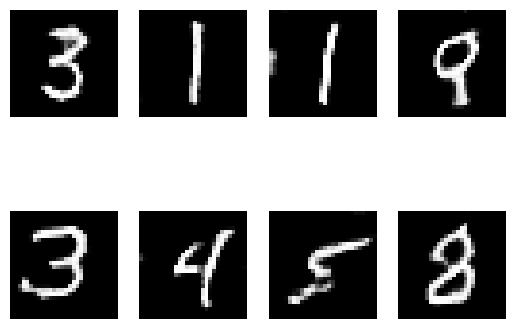


 Epoch: 6
Batch 500/1875 | Discriminator Loss: 1.3611090183258057 | Generator Loss: 0.8306809663772583
Batch 1000/1875 | Discriminator Loss: 1.3406217098236084 | Generator Loss: 0.7806193828582764
Batch 1500/1875 | Discriminator Loss: 1.2236380577087402 | Generator Loss: 0.9093939065933228

 Epoch: 7
Batch 500/1875 | Discriminator Loss: 1.2482882738113403 | Generator Loss: 0.7699974775314331
Batch 1000/1875 | Discriminator Loss: 1.2516963481903076 | Generator Loss: 0.8800134658813477
Batch 1500/1875 | Discriminator Loss: 1.2798876762390137 | Generator Loss: 0.695444643497467

 Epoch: 8
Batch 500/1875 | Discriminator Loss: 1.3286211490631104 | Generator Loss: 0.780617356300354
Batch 1000/1875 | Discriminator Loss: 1.3585948944091797 | Generator Loss: 0.8008609414100647
Batch 1500/1875 | Discriminator Loss: 1.1289087533950806 | Generator Loss: 0.8216016292572021

 Epoch: 9
Batch 500/1875 | Discriminator Loss: 1.3135521411895752 | Generator Loss: 0.6631807088851929
Batch 1000/1875 | Disc

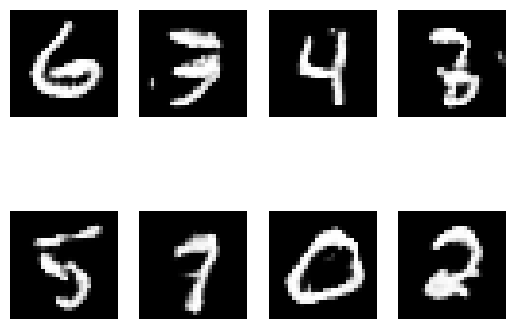


 Epoch: 11
Batch 500/1875 | Discriminator Loss: 1.372603416442871 | Generator Loss: 0.7925159931182861
Batch 1000/1875 | Discriminator Loss: 1.4307305812835693 | Generator Loss: 0.8477630019187927
Batch 1500/1875 | Discriminator Loss: 1.2709177732467651 | Generator Loss: 0.7189134359359741

 Epoch: 12
Batch 500/1875 | Discriminator Loss: 1.362485408782959 | Generator Loss: 1.0039821863174438
Batch 1000/1875 | Discriminator Loss: 1.2880597114562988 | Generator Loss: 0.6825345754623413
Batch 1500/1875 | Discriminator Loss: 1.4693851470947266 | Generator Loss: 0.6553189158439636

 Epoch: 13
Batch 500/1875 | Discriminator Loss: 1.4251089096069336 | Generator Loss: 0.8141937255859375
Batch 1000/1875 | Discriminator Loss: 1.3975696563720703 | Generator Loss: 0.6962043046951294
Batch 1500/1875 | Discriminator Loss: 1.5856221914291382 | Generator Loss: 0.822877049446106

 Epoch: 14
Batch 500/1875 | Discriminator Loss: 1.4018304347991943 | Generator Loss: 0.7094962000846863
Batch 1000/1875 | D

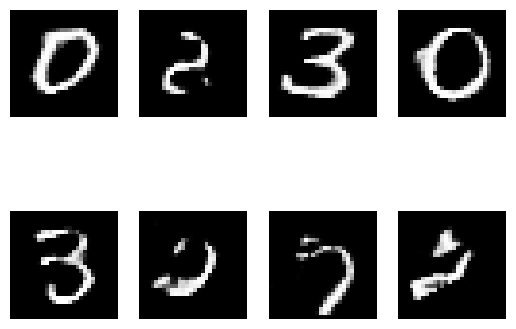


 Epoch: 16
Batch 500/1875 | Discriminator Loss: 1.3152189254760742 | Generator Loss: 0.8707640171051025
Batch 1000/1875 | Discriminator Loss: 1.3802478313446045 | Generator Loss: 0.6852668523788452
Batch 1500/1875 | Discriminator Loss: 1.2821645736694336 | Generator Loss: 0.6823265552520752

 Epoch: 17
Batch 500/1875 | Discriminator Loss: 1.3962149620056152 | Generator Loss: 0.7651469111442566
Batch 1000/1875 | Discriminator Loss: 1.1447309255599976 | Generator Loss: 0.6972031593322754
Batch 1500/1875 | Discriminator Loss: 1.4756269454956055 | Generator Loss: 0.6932510137557983

 Epoch: 18
Batch 500/1875 | Discriminator Loss: 1.2461068630218506 | Generator Loss: 0.6872397661209106
Batch 1000/1875 | Discriminator Loss: 1.4344251155853271 | Generator Loss: 0.8685746788978577
Batch 1500/1875 | Discriminator Loss: 1.3687435388565063 | Generator Loss: 0.6776440739631653

 Epoch: 19
Batch 500/1875 | Discriminator Loss: 1.3892889022827148 | Generator Loss: 0.7388972043991089
Batch 1000/1875 

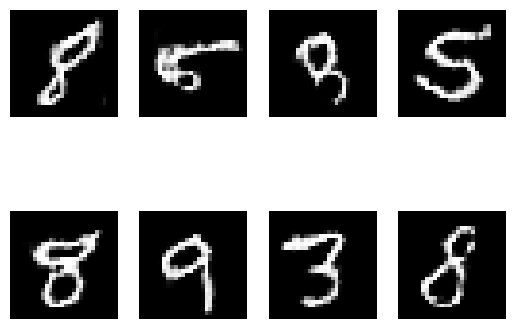

In [325]:
epochs = 20
batch_size = 32
mode_noise = 'uniform'
noise_size = 100
label_size = 10

loss_d_all = []
loss_g_all = []

for epoch in range(epochs):
    print(f"\n Epoch: {epoch+1}")
    loss_d, loss_g = train(data_loader,
                           generator,
                           discriminator,
                           loss_fn,
                           optimizer_d,
                           optimizer_g,
                           batch_size,
                           noise_size,
                           mode_noise,
                           device)
    loss_d_all.append(loss_d)
    loss_g_all.append(loss_g)

    if (epoch+1)% 5 == 0:
        generator.eval()
        with torch.inference_mode():
            z = create_noise(batch_size,
                             noise_size,
                             mode_noise,
                             device).unsqueeze(dim=2).unsqueeze(dim=3)
                
            labels_random = random_labels(data_size=10, batch_size=batch_size, device=device)

            image_generated = generator(z, labels_random)
            show_images(image_generated.cpu())

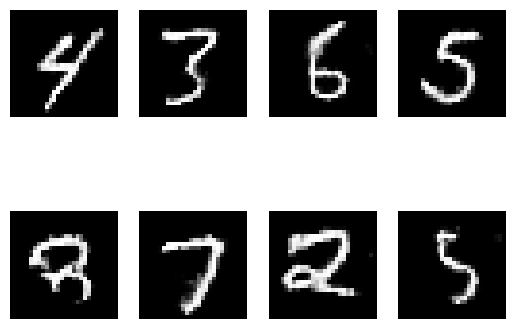

tensor([[[[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]]]], device='cuda:0')


In [331]:
generator.eval()
with torch.inference_mode():
            z = create_noise(batch_size,
                             noise_size,
                             mode_noise,
                             device).unsqueeze(dim=2).unsqueeze(dim=3)
                
            labels_random = random_labels(data_size=10, batch_size=batch_size, device=device)

            image_generated = generator(z, labels_random)
            show_images(image_generated.cpu())
            print(labels_random[0:2])